1. Постановка задачи

В данном проекте  произведем сегментацию клиентов металлургического комбината на основе их покупательской способности, частоты совершения заказов и срока давности последнего заказа, а также определим оптимальную стратегию взаимодействия с ними.


Техническая задача : построить модель кластеризации клиентов на основе их покупательской способности, частоты заказов и срока давности последней покупки, определить профиль каждого из кластеров.

Основные цели проекта:

Произвести предобработку набора данных.
Провести разведывательный анализ данных и выявить основные закономерности.
Сформировать категории товаров и клиентов.
Построить несколько моделей машинного обучения, решающих задачу кластеризации клиентов, определить количество кластеров и проинтерпретировать их.


2. Знакомство с данными.

In [730]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

from sklearn import mixture
from sklearn import manifold
from sklearn import pipeline
from sklearn import preprocessing
from sklearn import cluster
from sklearn import metrics
from sklearn import model_selection
from sklearn import decomposition
from sklearn import ensemble
import warnings

from IPython.display import display, HTML

warnings.filterwarnings("ignore")

plt.rcParams["patch.force_edgecolor"] = True

In [731]:
#Используемые версии бибилотек
print(pd.__version__)
print(sklearn.__version__)
print(np.__version__)

2.0.0
1.2.2
1.22.4


Познакомимся с нашими данными:

In [732]:
data = pd.read_excel(
    'C:/Users/Dmitriy/Downloads/Data Science lessons/Diploma/data 2017.xlsx'
)
print('Data shape: {}'.format(data.shape))
data.head(5)

Data shape: (201048, 6)


,Дата поставки,Наименование товара,"Вес, т","Ст-ть, usd",Страна,Покупатель
0,2017-01-01,NaN,-0.769231,0.0,Россия,165
1,2017-01-01,NaN,-0.769231,0.0,Россия,165
2,2017-01-01,NaN,0.000000,0.0,Россия,165
3,2017-01-01,NaN,-0.769231,0.0,Россия,165
4,2017-01-01,NaN,-0.769231,0.0,Россия,165


Итак, у нас есть данные о двухстах тысячах поставок металлургического завода. Каждая из них описывается следующими признаками:

* Дата поставки — дата совершения поставки, дата счета, дата транзакции;
* Наименование товара — вид поставляемой продукции;
* Вес,т — отгруженный вес в тоннах;
* Ст-ть, usd — стоимость отгруженной позиции; 
* Страна — страна куда поставляется продукция;
* Покуапател — идентификатор клиента, уникальный номер, присвоенный покупателю/клиенту;

Проведём анализ структуры таблицы.

In [194]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201048 entries, 0 to 201047
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   Дата поставки        201048 non-null  datetime64[ns]
 1   Наименование товара  130261 non-null  object        
 2   Вес, т               201048 non-null  float64       
 3   Ст-ть, usd           201048 non-null  float64       
 4   Страна               201048 non-null  object        
 5   Покупатель           201048 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(1), object(2)
memory usage: 9.2+ MB


4 столбца кодируются числовыми признаками, 1 в формате даты, 1 категориальный

In [195]:
#проверим на наличие пропусков в датасете
data.isnull().sum()

Дата поставки              0
Наименование товара    70787
Вес, т                     0
Ст-ть, usd                 0
Страна                     0
Покупатель                 0
dtype: int64

Удалим пропуски поскольку это металлические возвратные рамы на которых грузится в вагонах продукция в рулонах. Не имеют стоимости, поскольку являются собственностью продавца. Покупатели их возвращают при этом вес отображается отрицательным числом.

In [733]:
data=data.dropna()

In [734]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 130261 entries, 32283 to 201047
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   Дата поставки        130261 non-null  datetime64[ns]
 1   Наименование товара  130261 non-null  object        
 2   Вес, т               130261 non-null  float64       
 3   Ст-ть, usd           130261 non-null  float64       
 4   Страна               130261 non-null  object        
 5   Покупатель           130261 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(1), object(2)
memory usage: 7.0+ MB


In [735]:
data.isnull().sum().sum()

0

In [736]:
data.head()

,Дата поставки,Наименование товара,"Вес, т","Ст-ть, usd",Страна,Покупатель
32283,2017-01-10,HRS,47.692308,39543.173,Иран,174
32284,2017-01-10,HRS,47.930769,39740.883,Иран,174
32285,2017-01-02,PPGI,13.138462,29389.396,Казахстан,365
32286,2017-01-02,PPGI,35.169231,78669.982,Казахстан,365
32293,2017-01-16,PPGI,30.523077,68285.192,Казахстан,365


Определим период времени датасета

In [737]:
print('Начало периода:', data['Дата поставки'].min())
print('Конец периода:', data['Дата поставки'].max())

Начало периода: 2017-01-01 00:00:00
Конец периода: 2017-12-31 00:00:00


В датасете представлены данные за 2017 год

Добавим новый признак - "Цена за тонну"

In [738]:
data['Цена за тонну']=data['Ст-ть, usd']/data['Вес, т']

In [739]:
data.head()

,Дата поставки,Наименование товара,"Вес, т","Ст-ть, usd",Страна,Покупатель,Цена за тонну
32283,2017-01-10,HRS,47.692308,39543.173,Иран,174,829.131047
32284,2017-01-10,HRS,47.930769,39740.883,Иран,174,829.130924
32285,2017-01-02,PPGI,13.138462,29389.396,Казахстан,365,2236.897822
32286,2017-01-02,PPGI,35.169231,78669.982,Казахстан,365,2236.898001
32293,2017-01-16,PPGI,30.523077,68285.192,Казахстан,365,2237.166069


In [740]:
print('Максимальное цена:', round(data['Цена за тонну'].max(),2))
print('Минимальная цена:', round(data['Цена за тонну'].min(),2))

data['Цена за тонну'].describe(include='all')

Максимальное цена: 3217.55
Минимальная цена: 0.0


count    130261.000000
mean       1212.693618
std         468.655375
min           0.000000
25%        1036.337519
50%        1193.787778
75%        1418.837878
max        3217.552488
Name: Цена за тонну, dtype: float64

In [204]:
data[data['Цена за тонну']==0].info()

<class 'pandas.core.frame.DataFrame'>
Index: 743 entries, 33218 to 200212
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Дата поставки        743 non-null    datetime64[ns]
 1   Наименование товара  743 non-null    object        
 2   Вес, т               743 non-null    float64       
 3   Ст-ть, usd           743 non-null    float64       
 4   Страна               743 non-null    object        
 5   Покупатель           743 non-null    int64         
 6   Цена за тонну        743 non-null    float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(2)
memory usage: 46.4+ KB


In [205]:
print('Отгрузки с нулевой ценой,тонн', round(data[data['Цена за тонну']==0]['Вес, т'].sum(),2))
print('Отгрузки с ненулевой ценой,ттонн', round(data[data['Цена за тонну']!=0]['Вес, т'].sum(),2))
с=data[data['Цена за тонну']==0]['Вес, т'].sum()/data[data['Цена за тонну']!=0]['Вес, т'].sum()*100
print('% Отгрузки с нулевой ценой', round(с,2))

Отгрузки с нулевой ценой,тонн 4724.97
Отгрузки с ненулевой ценой,ттонн 2815309.89
% Отгрузки с нулевой ценой 0.17


Отгрузки с нулевой ценой это незначительные отгрузки на склады с последующей продажей физическим лицам, ими можно пренебречь, избавимся от них

In [741]:
data = data[data['Цена за тонну']!=0]

In [742]:
data['Цена за тонну'].describe(include='all')

count    129518.000000
mean       1219.650422
std         460.882764
min           0.004719
25%        1039.095330
50%        1193.852200
75%        1422.350680
max        3217.552488
Name: Цена за тонну, dtype: float64

Посмотрим на:
-сколько уникальных клиентов покупали товары за период выгрузки датасета,

-сколько уникальных стран содержится в столбце "Страна",

-укажем идентификатор самого популярного товара ("Наименование товара"):

In [743]:
print('Сколько уникальных клиентов покупали товары за период выгрузки датасета?:',
      len(data['Покупатель'].unique()))
print('Сколько уникальных стран содержится в столбце "Страна"?:',
      len(data['Страна'].unique()))


Сколько уникальных клиентов покупали товары за период выгрузки датасета?: 372
Сколько уникальных стран содержится в столбце "Страна"?: 19


In [744]:
data.groupby(['Наименование товара'], sort=False).agg({
    'Вес, т':'sum',
    
}).sort_values("Вес, т", ascending=False).head()

,"Вес, т"
Наименование товара,
HRC,961745.476923
CRC,552059.115385
HDGC,399314.715385
REBAR,319100.667692
HRS,293813.369231


Идентификатор самого популярного товара ("Наименование товара"): HRC -Hot rolled coil- это горячекатанный рулон, затем CRC -cold rolled coil холоднокатанный рулон, HDGC - hot deep galvanized coil - горячеоцинкованный рулон, REBAR - арматура, HRS- hot rolled sheet  - горячекатанный лист

In [210]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 129518 entries, 32283 to 201047
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   Дата поставки        129518 non-null  datetime64[ns]
 1   Наименование товара  129518 non-null  object        
 2   Вес, т               129518 non-null  float64       
 3   Ст-ть, usd           129518 non-null  float64       
 4   Страна               129518 non-null  object        
 5   Покупатель           129518 non-null  int64         
 6   Цена за тонну        129518 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(2)
memory usage: 7.9+ MB


Разведывательный анализ данных

Разведывательный анализ и исследование транзакции.

Задачи:

клиенты из каких стран покупают больше и чаще?;
присутствует ли в продажах сезонность (когда покупают чаще)?;
создать новые признаки, которые в дальнейшем понадобятся при формировании датасета о клиентах.

In [211]:
df=data.groupby(['Страна']).agg({
    'Покупатель':'count',
    
}).sort_values("Покупатель", ascending=False)
df['Страна'] = df.index
display(df)


,Покупатель,Страна
Страна,,
Россия,49545,Россия
Иран,36912,Иран
Казахстан,21241,Казахстан
Узбекистан,5902,Узбекистан
Афганистан,4713,Афганистан
Кыргызстан,2617,Кыргызстан
Таджикистан,2430,Таджикистан
Китай,1762,Китай
Азербайджан,1123,Азербайджан


Text(0.5, 1.0, 'Наибольшее количество клиентов по странам')

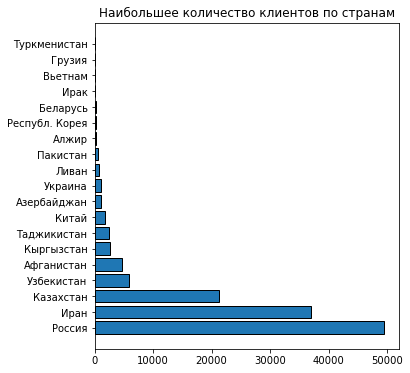

In [212]:
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(df['Страна'], df['Покупатель'], align="center")
plt.yticks(df['Страна'])

#

plt.title("Наибольшее количество клиентов по странам")

Топ-3: Россия, Иран, Казахстан

In [213]:
df=data.groupby(['Страна']).agg({
    'Вес, т':'sum',
    
}).sort_values("Вес, т", ascending=False)
df['Страна'] = df.index
display(df)

,"Вес, т",Страна
Страна,,
Россия,1.251947e+06,Россия
Иран,6.313185e+05,Иран
Казахстан,4.692179e+05,Казахстан
Узбекистан,1.602349e+05,Узбекистан
Афганистан,8.029483e+04,Афганистан
Таджикистан,7.488114e+04,Таджикистан
Кыргызстан,4.715272e+04,Кыргызстан
Азербайджан,2.844121e+04,Азербайджан
Украина,2.384198e+04,Украина


Text(0.5, 1.0, 'Наибольший объём закупок по странам, тонн')

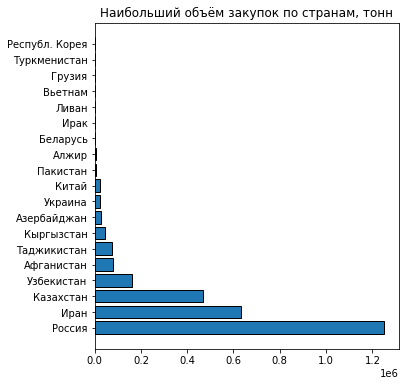

In [214]:
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(df['Страна'], df['Вес, т'], align="center")
plt.yticks(df['Страна'])

#

plt.title("Наибольший объём закупок по странам, тонн")

Топ-3: Россия, Иран, Казахстан

In [215]:
df=data.groupby(['Страна']).agg({
    'Ст-ть, usd':'sum',
    
}).sort_values("Ст-ть, usd", ascending=False)
df['Страна'] = df.index
display(df)

,"Ст-ть, usd",Страна
Страна,,
Россия,1.391966e+09,Россия
Иран,7.072150e+08,Иран
Казахстан,5.926270e+08,Казахстан
Узбекистан,2.037795e+08,Узбекистан
Афганистан,1.049950e+08,Афганистан
Таджикистан,8.027599e+07,Таджикистан
Кыргызстан,6.423370e+07,Кыргызстан
Азербайджан,4.028228e+07,Азербайджан
Украина,3.405217e+07,Украина


Text(0.5, 1.0, 'Наибольший объём выручки по странам, usd')

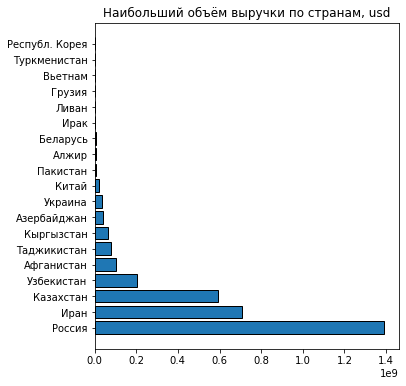

In [216]:
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(df['Страна'], df['Ст-ть, usd'], align="center")
plt.yticks(df['Страна'])

#

plt.title("Наибольший объём выручки по странам, usd")

Топ-3: Россия, Иран, Казахстан

Добавим в таблицу с транзакциями признаки месяца

Построим визуализацию, отражающую распределение суммарной выручки от заказов по месяцам

In [217]:
data['Месяц поставки'] = pd.to_datetime(data['Дата поставки']).dt.month

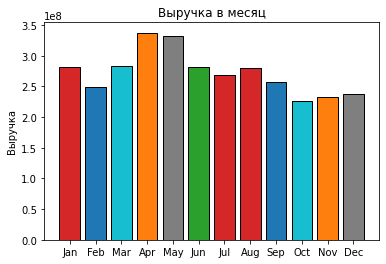

In [218]:
fig, ax = plt.subplots()

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug',
          'Sep', 'Oct', 'Nov', 'Dec']  # data3[purchase_month'].unique()
counts = data.groupby(['Месяц поставки'])['Ст-ть, usd'].sum()
bar_labels = data['Месяц поставки'].unique()
bar_colors = ['tab:red', 'tab:blue', 'tab:cyan',
              'tab:orange', 'tab:grey', 'tab:green', 'tab:red']

ax.bar(months, counts, label=bar_labels, color=bar_colors)

ax.set_ylabel('Выручка')
ax.set_title('Выручка в месяц')
#ax.legend(title='day color')

plt.show()

4 - номер самого прибыльного для компании месяца, затем 5. Покупатели в апреле-мае увеличивают закупки для того, чтобы создать запас перед летним сезоном

In [219]:
data.groupby(['Наименование товара'])['Вес, т'].sum().sort_values(ascending=False)

Наименование товара
HRC      961745.476923
CRC      552059.115385
HDGC     399314.715385
REBAR    319100.667692
HRS      293813.369231
CRS      110347.569231
PPGI      81881.230769
TPS       39604.469231
TPC       26119.007692
CRNC       6751.576923
BPC        6287.330769
CVC        4975.730769
HDGS       4775.238462
HRNC       4010.461538
H_CBL      2567.096923
HDGP       1152.661538
ROUND       371.163077
SCRAP       175.815385
CVS         142.569231
NONCD        67.846154
PPGIP        36.003846
STR          10.776923
Name: Вес, т, dtype: float64

In [220]:
pivot_table = data.groupby(['Наименование товара','Месяц поставки']).agg({
    'Вес, т':'sum',
    
  
}).reset_index().rename(columns={'Вес, т': 'месячный объём'})

pivot_table=pivot_table[pivot_table['месячный объём']>10000]
pivot_table.head()

,Наименование товара,Месяц поставки,месячный объём
6,CRC,1,36516.453846
7,CRC,2,29399.038462
8,CRC,3,47429.976923
9,CRC,4,53284.246154
10,CRC,5,54159.800000


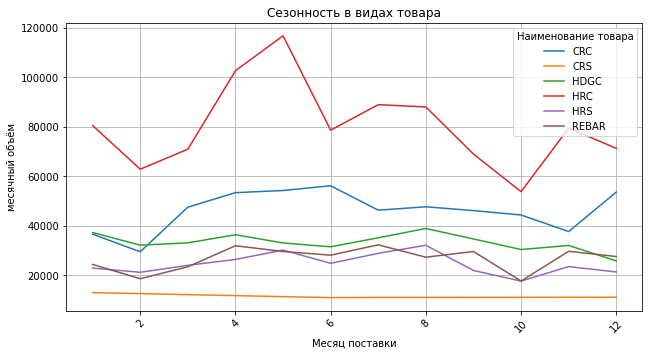

In [221]:
# создаём фигуру размером 8x4
fig = plt.figure(figsize=(8, 4))
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1])
# строим lineplot для покупательской способности в каждой группе
sns.lineplot(x='Месяц поставки', y='месячный объём', data=pivot_table, hue='Наименование товара', ax=ax)
# задаём подпись к графику
ax.set_title('Сезонность в видах товара')
# задаём поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation = 45)
# задаём отображение сетки
ax.grid(True);

Среди самых объёмных видов товара сезонность отсутствует в CRS - холоднокатанный лист, ярче всего выражена в HRC, CRC, далее по убыванию в HDGC, HRS, REBAR. HRC, CRC покупают заводы, производящие трубу, которая затем используется в строительстве, которое очень активно в летние месяцы. REBAR - арматура тоже для строительства. HDGC - горячеоцинкованный рулон для производства заборов, крыш, вентиляции, окон, сендвич-панелей- все для строительства. Февраль традиционно самый "провальный месяц", далее рынок оживляется, покупатели строят стоки для активной работы в летний сезон.

In [745]:
data.head(1)

,Дата поставки,Наименование товара,"Вес, т","Ст-ть, usd",Страна,Покупатель,Цена за тонну
32283,2017-01-10,HRS,47.692308,39543.173,Иран,174,829.131047


RFM-сегментация клиентов: часть 1

Cформируем признаки, на основе которых мы будем производить сегментацию клиентов по методу RFM.


Сгруппируем клиентов на основе следующих параметров:

Recency (Давность) — давность последней покупки клиента;
Frequency (Частота) — общее количество покупок клиента;
Monetary Value (Денежная ценность) — сколько денег потратил клиент.

In [747]:
import math
data['zero_date'] = '2016-12-31 00:00:00'
data['Recency'] = (pd.to_datetime(data['Дата поставки'])-pd.to_datetime(
    data['zero_date'])).apply(lambda x: math.floor(x / np.timedelta64(1, 'D')))

In [835]:
data.head(1)

,Дата поставки,Наименование товара,"Вес, т","Ст-ть, usd",Страна,Покупатель,Цена за тонну,zero_date,Recency
32283,2017-01-10,HRS,47.692308,39543.173,Иран,174,829.131047,2016-12-31 00:00:00,10


In [836]:
rfm = data.groupby(['Покупатель']).agg(
    Monetary_Value=pd.NamedAgg(column='Ст-ть, usd', aggfunc='sum'),
    Recency=pd.NamedAgg(column='Recency', aggfunc='min'),
    Frequency=pd.NamedAgg(column="Дата поставки", aggfunc='nunique'),

)
rfm

,Monetary_Value,Recency,Frequency
Покупатель,,,
1,59034.319,9,1
2,1009600.709,4,17
3,126156.133,67,1
4,313714.277,259,5
5,1079512.053,15,12
...,...,...,...
379,111792.884,225,2
380,222306.025,306,3
381,4334542.173,84,26


Посмотрим сколько клиентов совершили покупку более 200 дней назад?
Сколько заказов в среднем делает клиент (за представленный годовой период)? Ответ округлим до целого числа.



In [837]:
rfm[(rfm['Recency'] > 200)].count()[0]


78

In [838]:
round(rfm['Frequency'].mean(), 0)

34.0

Строим коробчатые диаграммы для каждого из признаков:

In [839]:
rfm_table = rfm
boxes = [px.box(rfm_table, x=column) for column in rfm_table.columns]

fig = make_subplots(
    rows=1, cols=3,
    subplot_titles=(
        "Recency", "Frequency", "Monetary"
    )
)

for i, box in enumerate(boxes):
    fig.add_trace(boxes[i]['data'][0], row=1, col=i+1)

fig.update_layout(showlegend=True)
fig.show()

Удалим из RFM-таблицы записи о клиентах, для которых выполняется хотя бы одно из условий:

𝑓𝑟𝑒𝑞𝑢𝑒𝑛𝑐𝑦>𝑓𝑟𝑒𝑞𝑢𝑒𝑛𝑐𝑦0.95
 
𝑚𝑜𝑛𝑒𝑡𝑎𝑟𝑦>𝑚𝑜𝑛𝑒𝑡𝑎𝑟𝑦0.95
 
где  𝑓𝑟𝑒𝑞𝑢𝑒𝑛𝑐𝑦0.95
  и  𝑚𝑜𝑛𝑒𝑡𝑎𝑟𝑦0.95
  - квантили уровня 0.95 для соответствующих признаков.

In [840]:
rfm_table = rfm_table[(rfm_table['Frequency'] <= rfm_table['Frequency'].quantile(
    0.95)) & (rfm_table['Monetary_Value'] <= rfm_table['Monetary_Value'].quantile(0.95))]

rfm_table.info()

<class 'pandas.core.frame.DataFrame'>
Index: 350 entries, 1 to 383
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Monetary_Value  350 non-null    float64
 1   Recency         350 non-null    int64  
 2   Frequency       350 non-null    int64  
dtypes: float64(1), int64(2)
memory usage: 10.9 KB


У нас остались данные о 350 клиентах в RFM-таблице

In [841]:
rfm_table_cleaned = rfm_table
boxes = [px.box(rfm_table_cleaned, x=column)
         for column in rfm_table_cleaned.columns]
fig = make_subplots(
    rows=1, cols=3,
    subplot_titles=(
        "Recency", "Frequency", "Monetary"
    )
)

for i, box in enumerate(boxes):
    fig.add_trace(boxes[i]['data'][0], row=1, col=i+1)

fig.update_layout(showlegend=True)
fig.show()

Этап кластеризации. 
Для начала оценим, как распределены наблюдения в пространстве признаков. У нас всего три параметра, по которым мы хотим кластеризовать клиентов, поэтому данные визуализируем в виде трёхмерной диаграммы рассеяния.

Построим визуализацию нашего трёхмерного пространства признаков:

Text(0.5, 0, 'Monetary_Value')

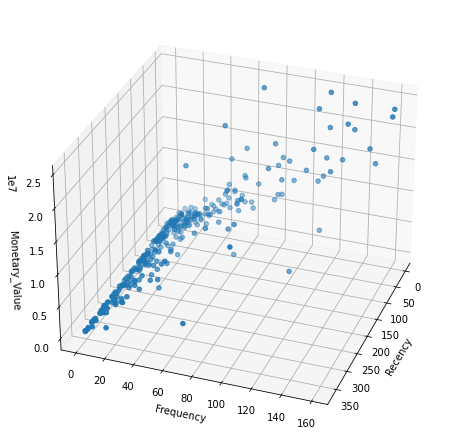

In [842]:
# создадим трёхмерный объект
fig = plt.figure(figsize=(6, 6))
ax = Axes3D(fig)
# добавим дополнительную ось в объект картинки
fig.add_axes(ax)
ax.azim = 20
ax.elev = 30

# визуализируем данные, передав значения x, y, z, а также информацию о группировке данных по цветам
ax.scatter(
    rfm_table_cleaned['Recency'].to_list(),
    rfm_table_cleaned['Frequency'].to_list(),
    rfm_table_cleaned['Monetary_Value'].to_list()
)
# добавим оси
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary_Value')

Начнём с метода главных компонент (PCA).  Стандартизируем/нормализуем данные.

Обернём эти шаги по предобработке данных в pipeline.

Создадим pipeline, в котором будут шаги:

стандартизация с помощью StandardScaler с параметрами по умолчанию;
метод главных компонент с двумя компонентами.
Обучим pipeline на RFM-таблице, очищенной от выбросов, и применим к ней трансформацию.



In [843]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.pipeline import Pipeline


pipeline1 = Pipeline([('ss', StandardScaler()), ('pCa', PCA(n_components=2))])
X = pipeline1.fit_transform(rfm_table_cleaned)
print(pipeline1['pCa'].explained_variance_ratio_)

[0.70347877 0.26111153]


Первая главная компонента объясняет 70% долю дисперсии исходных данных.

In [844]:
principalComponents = X

Визуализировав пространство главных компонент после декомпозиции мы получим следующую картину:

<AxesSubplot:>

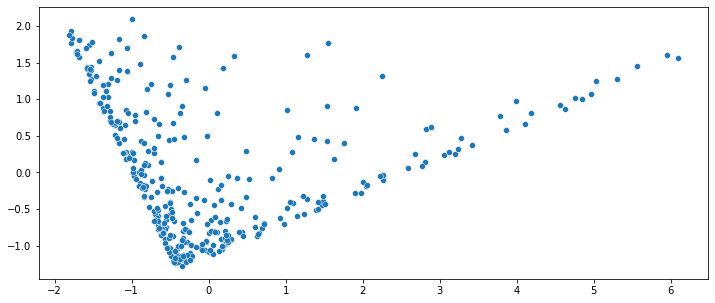

In [845]:
fig = plt.figure(figsize=(12, 5))
sns.scatterplot(x=principalComponents.T[0], y=principalComponents.T[1])

Попробуем разделить это пространство главных компонент на сегменты.

Воспользуемся методом k-means.

Подберем оптимальное количество кластеров для метода k-means с помощью коэффициента силуэта, перебирая возможные значения от 2 до 10 включительно.

В качестве значения параметра random_state возьмем число 42. Остальные параметры -  по умолчанию.



n_clusters= 2
silhouette_score= 0.5896977680154194
n_clusters= 3
silhouette_score= 0.52373425799871
n_clusters= 4
silhouette_score= 0.5383443424556975
n_clusters= 5
silhouette_score= 0.4709515480316769
n_clusters= 6
silhouette_score= 0.4614871475450921
n_clusters= 7
silhouette_score= 0.4273971207735892
n_clusters= 8
silhouette_score= 0.4375339925255446
n_clusters= 9
silhouette_score= 0.44039331959982403
n_clusters= 10
silhouette_score= 0.4103171412287004


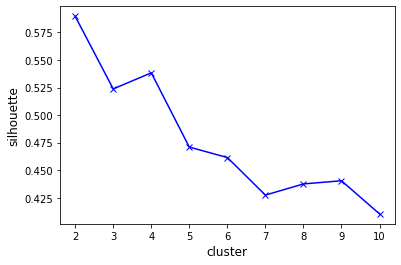

In [846]:
from sklearn.cluster import KMeans

silhouettes = []

# определяем алгоритм кластеризации
i = 0
for i in range(2, 11):
    km = KMeans(n_clusters=i, random_state=42)
#    km.fit_predict(rfm_std)#principalComponents
    km.fit_predict(principalComponents)
    score = metrics.silhouette_score(
        principalComponents, km.labels_, metric='euclidean')
    silhouettes.append(score)
    
    print('n_clusters=', i)
    print('silhouette_score=', score)
plt.xlabel("cluster", fontsize=12)
plt.ylabel("silhouette", fontsize=12)
plt.plot([i for i in range(2, 11)], silhouettes, 'xb-')
# вычисляем значение коэффициента силуэта

1) Судя по полученным результатам лучше всего взять 3 кластера.

2) Максимальное значение коэффициента силуэта  0.6.

Теперь возьмём EM-алгоритм.

Подберем оптимальное количество кластеров для EM-алгоритма (GaussianMixture) с помощью коэффициента силуэта, перебирая возможные значения от 2 до 10 включительно. В качестве значения параметра random_state возьмем число 42. Остальные параметры -  по умолчанию.



n_clusters= 2
silhouette_score= 0.500478449710129
n_clusters= 3
silhouette_score= 0.17990274210609283
n_clusters= 4
silhouette_score= 0.14504618915604534
n_clusters= 5
silhouette_score= 0.11017724244871557
n_clusters= 6
silhouette_score= 0.048782394912070766
n_clusters= 7
silhouette_score= 0.14896772200359415
n_clusters= 8
silhouette_score= 0.13193429276398597
n_clusters= 9
silhouette_score= 0.11142459351353645
n_clusters= 10
silhouette_score= 0.1474463828746824


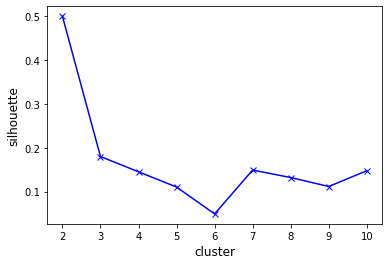

In [847]:
from sklearn.mixture import GaussianMixture
silhouettes = []


for i in range(2, 11):
    em = GaussianMixture(n_components=i, random_state=42)
    sss = em.fit_predict(principalComponents)
    score = metrics.silhouette_score(
        principalComponents, sss, metric='euclidean')
    silhouettes.append(score)
    print('n_clusters=', i)
    print('silhouette_score=', score)
    
plt.xlabel("cluster", fontsize=12)
plt.ylabel("silhouette", fontsize=12)
plt.plot([i for i in range(2, 11)], silhouettes, 'xb-')

1) Судя по полученным результатам лучше всего взять 3 кластера.

2) Максимальное значение коэффициента силуэта 0.5.

Посмотрим на распределение кластеров.

1) Определить лучшую модель. Для модели с оптимальным количеством кластеров наибольший коэффициент силуэта 0.6 - K-Means

2) Обучим лучшую модель с подобранным ранее количеством кластеров на декомпозированных данных. 

In [848]:
km = KMeans(n_clusters=3, random_state=42)
rfm_km = km.fit_predict(principalComponents)
b = km.labels_

counts = np.unique(b, return_counts=True)
for count in counts:
    print(count, end=' ')

[0 1 2] [191  44 115] 

In [849]:
s = pd.Series(rfm_km)
s.value_counts().max()

191

191 клиент попал в самый большой кластер

<AxesSubplot:>

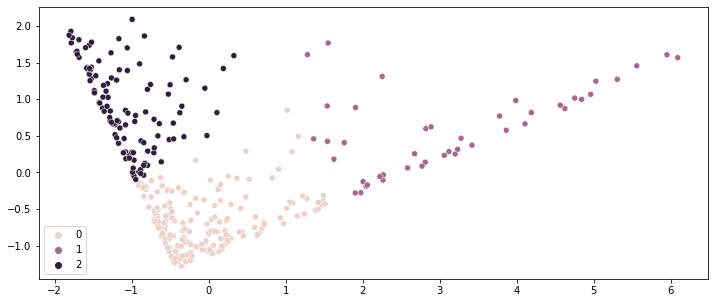

In [850]:
fig = plt.figure(figsize=(12, 5))
sns.scatterplot(x=principalComponents.T[0],
                y=principalComponents.T[1], hue=rfm_km,)

Итак, у нас есть три сегмента клиентов. Попробуем составить профиль для этих сегментов.

Для составления профиля кластеров вернемся от декомпозированных данных к RFM-таблице, очищенной от выбросов. Сгруппируем RFM-таблицу по полученным кластерам и рассчитаем среднее по каждому из признаков.

In [851]:
rfm_table_cleaned['Cluster'] = rfm_km
rfm_table_cleaned

,Monetary_Value,Recency,Frequency,Cluster
Покупатель,,,,
1,59034.319,9,1,0
2,1009600.709,4,17,0
3,126156.133,67,1,0
4,313714.277,259,5,2
5,1079512.053,15,12,0
...,...,...,...,...
379,111792.884,225,2,2
380,222306.025,306,3,2
381,4334542.173,84,26,0


In [852]:
rfm_mean = rfm_table_cleaned.groupby(['Cluster']).agg(
    Recency_mean=pd.NamedAgg(column='Recency', aggfunc='mean'),
    Frequency_mean=pd.NamedAgg(column="Frequency", aggfunc='mean'),
    Monetary_mean=pd.NamedAgg(column='Monetary_Value', aggfunc='mean'),
)
rfm_mean

,Recency_mean,Frequency_mean,Monetary_mean
Cluster,,,
0,47.39267,15.193717,1.597922e+06
1,31.75000,90.909091,1.337415e+07
2,236.80000,8.217391,9.626253e+05


Максимальное среднее значение признака Frequency в полученной таблице:

In [853]:
rfm_mean['Frequency_mean'].max()

90.9090909090909

Полярная диаграмма

In [854]:
def plot_cluster_profile(grouped_data, n_clusters):
    # Нормализуем сгруппированные данные, приводя их к масштабу 0-1.
    scaler = preprocessing.MinMaxScaler()
    grouped_data = pd.DataFrame(scaler.fit_transform(
        grouped_data), columns=grouped_data.columns)
    # Создаем список признаков
    features = grouped_data.columns
    # Создаем пустую фигуру
    fig = go.Figure()
    # В цикле визуализируем полярную диаграмму для каждого кластера
    for i in range(n_clusters):
        # Создаем полярную диаграмму и добавляем ее на общий график
        fig.add_trace(go.Scatterpolar(
            r=grouped_data.iloc[i].values,  # радиусы
            theta=features,  # название засечек
            fill='toself',  # заливка многоугольника цветом
            name=f'Cluster {i}',  # название - номер кластера
        ))
    # Обновляем параметры фигуры
    fig.update_layout(
        showlegend=True,  # отображение легенды
        autosize=False,  # устаналиваем свои размеры графика
        width=800,  # ширина (в пикселях)
        height=800,  # высота (в пикселях)
    )
    # Отображаем фигуру
    fig.show()

Визуализируем профили кластеров в виде полярной диаграммы на основе средних RFM-характеристик, вычисленных для каждого кластера.


In [855]:
plot_cluster_profile(rfm_mean, 3)

Кластер соответствует «лояльным» клиентам, которые приносят наибольший доход, совершают покупки чаще всего, а давность их последней покупки наименьшая - этол  кластер 1

Кластер соответствует «промежуточным» клиентам, которые являются активными, но покупают не так часто и много, как лояльные клиенты. В то же время эти клиенты не являются «потерянными» - это кластер 0.
Кластер 1 соответствует «потерянным» клиентам, которые купили меньше всего товара, и их последняя покупка была совершена очень давно.

Воспользуемся алгоритмом t-SNE и трансформируем RFM-таблицу, очищенную от выбросов, в двухмерное представление, масштабируем признаки.

Обернём шаги по предобработке данных в pipeline.

Создадим pipeline, который будет содержать следующие шаги:

стандартизация с помощью StandardScaler с параметрами по умолчанию;
алгоритм t-SNE с двумя компонентами, параметрами perplexity=50 и random_state=100.
Обучим pipeline на RFM-таблице (очищенной от выбросов), полученной ранее, и применим к ней трансформацию.

In [856]:
#избавимся от кластеров
rfm_table_cleaned = rfm_table_cleaned.drop(['Cluster'], axis=1)
rfm_table_cleaned.head()

,Monetary_Value,Recency,Frequency
Покупатель,,,
1,59034.319,9,1
2,1009600.709,4,17
3,126156.133,67,1
4,313714.277,259,5
5,1079512.053,15,12


In [857]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

pipeline2 = Pipeline([('ssc', StandardScaler()), ('tsne', TSNE(
    n_components=2, perplexity=50, random_state=100, init='pca'))])
XX = pipeline2.fit_transform(rfm_table_cleaned)
print(pipeline2['tsne'].kl_divergence_)

0.18732167780399323


 - значение дивергенции Кульбака — Лейблера для обученного алгоритма t-SNE

In [858]:
rfm_table_processed = pd.DataFrame(
    XX, columns=['axis-1', 'axis-2'], index=rfm_table_cleaned.index)
rfm_table_processed

,axis-1,axis-2
Покупатель,,
1,2.829515,-9.561172
2,7.475344,-6.090868
3,-1.658601,-5.376214
4,-12.682503,4.756009
5,5.698689,-6.445992
...,...,...
379,-11.753762,3.000064
380,-14.418049,6.160693
381,7.668732,-0.366132


<AxesSubplot:>

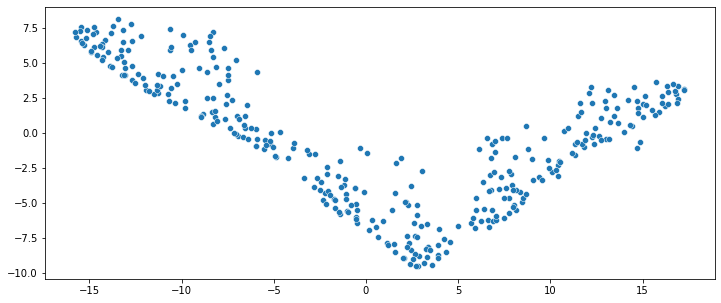

In [859]:
fig = plt.figure(figsize=(12, 5))
sns.scatterplot(x=XX.T[0], y=XX.T[1])

Визуализировав пространство после декомпозиции с помощью t-SNE, мы получили следующую картину:

Как и ожидалось от t-SNE, алгоритм сгруппировал наиболее похожие объекты в подобие кластеров, причём эти кластеры можно определить.

Теперь воспользуемся алгоритмами кластеризации, чтобы сформировать новые сегменты клиентов.


Возьмем  метод k-means. Подберем оптимальное количество кластеров для метода k-means с помощью коэффициента силуэта, перебирая возможные значения от 3 до 8 включительно. В качестве значения параметра random_state возьмем число 42. Остальные параметры оставим по умолчанию.



n_clusters= 3
silhouette_score= 0.5752359
n_clusters= 4
silhouette_score= 0.52155036
n_clusters= 5
silhouette_score= 0.52159476
n_clusters= 6
silhouette_score= 0.51774955
n_clusters= 7
silhouette_score= 0.5078809
n_clusters= 8
silhouette_score= 0.47558394


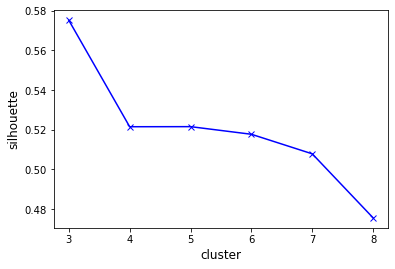

In [860]:
silhouettes = []



for i in range(3, 9):
    km = KMeans(n_clusters=i, random_state=42)
#    sss=km.fit_predict(rfm_table_processed)
    km.fit_predict(rfm_table_processed)
    score = metrics.silhouette_score(rfm_table_processed, km.labels_)
    silhouettes.append(score)
    print('n_clusters=', i)
    print('silhouette_score=', score)
plt.xlabel("cluster", fontsize=12)
plt.ylabel("silhouette", fontsize=12)
plt.plot([i for i in range(3, 9)], silhouettes, 'xb-')

1) Судя по полученным результатам лучше всего взять 4 кластера.

2) Максимальное значение коэффициента силуэта 0.56.

Воспользуемся EM-алгоритом.

Подберем оптимальное количество кластеров для EM-алгоритма (GaussianMixture) с помощью коэффициента силуэта, перебирая возможные значения от 3 до 8 включительно.

В качестве значения параметра random_state возьмем число 42. Остальные параметры оставим по умолчанию.


n_clusters= 3
silhouette_score= 0.5466872
n_clusters= 4
silhouette_score= 0.44282836
n_clusters= 5
silhouette_score= 0.37637198
n_clusters= 6
silhouette_score= 0.3868369
n_clusters= 7
silhouette_score= 0.44681928
n_clusters= 8
silhouette_score= 0.40447092


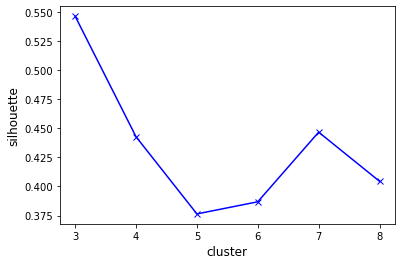

In [861]:
silhouettes = []
for i in range(3, 9):
    em = GaussianMixture(n_components=i, random_state=42)
    sss = em.fit_predict(rfm_table_processed)
    score = metrics.silhouette_score(
        rfm_table_processed, sss, metric='euclidean')
    silhouettes.append(score)
    print('n_clusters=', i)
    print('silhouette_score=', score)

plt.xlabel("cluster", fontsize=12)
plt.ylabel("silhouette", fontsize=12)
plt.plot([i for i in range(3, 9)], silhouettes, 'xb-')

1) Судя по полученным результатам лучше всего взять 5 кластера.

2) Максимальное значение коэффициента силуэта 0.55.

Наконец, воспользуеся алгоритмом алгомеративной кластеризации (AgglomerativeClustering).

Подберем оптимальное количество кластеров для алгоритма агломеративной кластеризации с помощью коэффициента силуэта, перебирая возможные значения от 3 до 8 включительно.

Все параметры, за исключением числа кластеров, оставим по умолчанию.



n_clusters= 3
silhouette_score= 0.54956746
n_clusters= 4
silhouette_score= 0.54614687
n_clusters= 5
silhouette_score= 0.5054873
n_clusters= 6
silhouette_score= 0.5030231
n_clusters= 7
silhouette_score= 0.47950214
n_clusters= 8
silhouette_score= 0.46664116


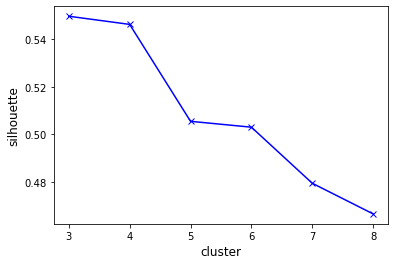

In [862]:
from sklearn.cluster import AgglomerativeClustering

silhouettes = []
for i in range(3, 9):
    ac = AgglomerativeClustering(n_clusters=i)
    sss = ac.fit_predict(rfm_table_processed)
    score = metrics.silhouette_score(
        rfm_table_processed, sss, metric='euclidean')
    silhouettes.append(score)
    print('n_clusters=', i)
    print('silhouette_score=', score)
plt.xlabel("cluster", fontsize=12)
plt.ylabel("silhouette", fontsize=12)
plt.plot([i for i in range(3, 9)], silhouettes, 'xb-')

1) Судя по полученным результатам лучше всего взять 5 кластеров.

2) Максимальное значение коэффициента силуэта 0.55.

Посмотрим на распределение кластеров.

1) Сначала определим лучшую модель. Для K-Means  количеством кластеров 4 коэффициент силуэта наибольший



2) Обучим лучшую модель с подобранным ранее количеством кластеров на декомпозированных данных. 

In [863]:
km = KMeans(n_clusters=4, random_state=42)
ss=km.fit_predict(X)
b=km.labels_

counts = np.unique(b, return_counts=True)
for count in counts:
    print(count, end=' ')

[0 1 2 3] [ 48 104 181  17] 

In [864]:
counts[1].max()

181

-клиентов попало в самый большой кластер.

<AxesSubplot:>

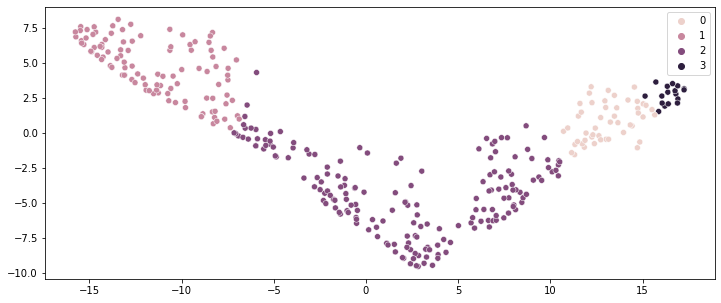

In [865]:
fig = plt.figure(figsize=(12, 5))
sns.scatterplot(x=XX.T[0], y=XX.T[1], hue=ss,)

Для составления профиля кластеров вернемся от декомпозированных данных к RFM-таблице (очищенной от выбросов).

Сгруппируем RFM-таблицу по полученным кластерам и рассчитаем среднее по каждому из признаков. Для наглядности округлим все значения в столбцах до целого числа.


In [866]:
rfm_table_cleaned['Cluster'] = ss
rfm_table_cleaned.head()

,Monetary_Value,Recency,Frequency,Cluster
Покупатель,,,,
1,59034.319,9,1,2
2,1009600.709,4,17,2
3,126156.133,67,1,2
4,313714.277,259,5,1
5,1079512.053,15,12,2


In [868]:
rfm_mean = rfm_table_cleaned.groupby(['Cluster']).agg(
    Recency_mean=pd.NamedAgg(column='Recency', aggfunc='mean'),
    Frequency_mean=pd.NamedAgg(column="Frequency", aggfunc='mean'),
    Monetary_mean=pd.NamedAgg(column='Monetary_Value', aggfunc='mean'),
)
rfm_mean_round = rfm_mean.round(0)
rfm_mean_round

,Recency_mean,Frequency_mean,Monetary_mean
Cluster,,,
0,40.0,61.0,8134085.0
1,246.0,9.0,1028543.0
2,55.0,11.0,1050156.0
3,7.0,121.0,18640286.0


In [869]:
rfm_mean_round['Recency_mean'].max()

246.0

-максимальное среднее значение признака Recency в полученной таблице

Визуализируем профили кластеров в виде полярной диаграммы на основе средних RFM-характеристик, вычисленных для каждого кластера.

Проанализируем кластеры и на основе анализа сопоставим номер кластера и его описание.



In [870]:
plot_cluster_profile(rfm_mean, 4)

Кластер 3 соответствует «лояльным» клиентам, которые приносят наибольший доход, совершают покупки чаще всего, а давность их последней покупки наименьшая.
Кластер 0 соответствует «перспективным» клиентам, которые являются активными покупателями, но покупают не так часто и не так много, как лояльные клиенты.
Кластер 2 соответствует «подвисшим» клиентам, которые относительно недавно сделали несколько заказов на небольшие суммы. Потенциально эти клиенты могут быть переведены в кластер «перспективных».
Кластер 1 соответствует клиентам «в зоне риска», которые несколько раз покупали товары на небольшие суммы, однако их последняя покупка была совершена более пяти месяцев назад.


In [871]:
#pip install tensorflow

Воспользуемся Deep Learning для определения количества кластеров

In [872]:
from tensorflow.keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers.legacy import Adam
 

In [873]:

rfm_table_cleaned.head()

,Monetary_Value,Recency,Frequency,Cluster
Покупатель,,,,
1,59034.319,9,1,2
2,1009600.709,4,17,2
3,126156.133,67,1,2
4,313714.277,259,5,1
5,1079512.053,15,12,2


In [874]:
rfm_table_cleaned=rfm_table_cleaned.reset_index()

In [875]:
rfm_table_cleaned.head()

,Покупатель,Monetary_Value,Recency,Frequency,Cluster
0,1,59034.319,9,1,2
1,2,1009600.709,4,17,2
2,3,126156.133,67,1,2
3,4,313714.277,259,5,1
4,5,1079512.053,15,12,2


In [877]:
rfm_table_cleaned['Cluster'].unique()

array([2, 1, 0, 3])

In [878]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(rfm_table_cleaned, test_size=0.2, random_state=42)
print(train.shape)

(280, 5)


In [880]:
rfm_table_cleaned['Cluster'].unique()

array([2, 1, 0, 3])

In [881]:
n_users = int(rfm_table_cleaned['Покупатель'].max())


print(n_users)

383


In [882]:
n_Monetary_Value = int(rfm_table_cleaned['Monetary_Value'].max())



print(n_Monetary_Value)

24552288


In [883]:
n_Recency=int(rfm_table_cleaned['Recency'].max())

n_Frequency=int(rfm_table_cleaned['Frequency'].max())

In [884]:
n_Recency, n_Frequency

(364, 159)

Создаем эмбеддинги :

In [885]:
user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(n_users+1, 5, name="User-Embedding")(user_input)
user_vec = Flatten(name="Flatten-Users")(user_embedding)

In [886]:
Monetary_Value_input = Input(shape=[1], name="Monetary_Value-Input")
Monetary_Value_embedding = Embedding(n_Monetary_Value+1, 5, name="Monetary_Value-Embedding")(Monetary_Value_input)
Monetary_Value_vec = Flatten(name="Flatten-Monetary_Value")(Monetary_Value_embedding)

In [887]:
Recency_input = Input(shape=[1], name="Recency-Input")
Recency_embedding = Embedding(n_Recency+1, 5, name="Recency-Embedding")(Recency_input)
Recency_vec = Flatten(name="Flatten-Recency")(Recency_embedding)

In [888]:
Frequency_input = Input(shape=[1], name="Frequency-Input")
Frequency_embedding = Embedding(n_Frequency+1, 5, name="Frequency-Embedding")(Frequency_input)
Frequency_vec = Flatten(name="Flatten-Frequency")(Frequency_embedding)

соединяем представления:

In [889]:
conc = Concatenate()([user_vec,Monetary_Value_vec,Recency_vec, Frequency_vec])

начинаем «собирать» нашу нейронную сеть из слоёв. Dense обозначает полносвязный слой. Также мы обозначаем для него количество нейронов и данные, которые идут на вход.

In [890]:
conc.shape

TensorShape([None, 20])

In [891]:
fc1 = Dense(128, activation='relu')(conc)
fc2 = Dense(32, activation='relu')(fc1)
out = Dense(1)(fc2)

Собираем модель — передаём входные данные, а также архитектуру нейронной сети:

In [892]:
model2 = Model([user_input, Monetary_Value_input,Recency_input,Frequency_input], out)

Зададим алгоритм оптимизации и метрику, которую мы будем оптимизировать. В данном случае будем использовать метод adam и среднеквадратичную ошибку:

In [893]:
model2.compile(optimizer = 'adam',loss =  'mean_squared_error')

In [894]:
history = model2.fit([train.Покупатель, train.Monetary_Value,train.Recency, train.Frequency], train.Cluster, epochs=5, verbose=1)

Epoch 1/5
9/9 [==============================] - 14s 1s/step - loss: 2.7189
Epoch 2/5
9/9 [==============================] - 13s 1s/step - loss: 2.4092
Epoch 3/5
9/9 [==============================] - 12s 1s/step - loss: 1.9812
Epoch 4/5
9/9 [==============================] - 12s 1s/step - loss: 1.4136
Epoch 5/5
9/9 [==============================] - 12s 1s/step - loss: 0.8328


In [895]:
model2.evaluate([test.Покупатель, test.Monetary_Value,test.Recency, test.Frequency], test.Cluster)

3/3 [==============================] - 0s 9ms/step - loss: 0.6744


0.6743669509887695

Для улучшения качества модели каким-то образом модифицируют нейронную сеть: дополняют её, увеличивают время обучения. Добавим ещё один полносвязный слой с восемью нейронами после полносвязного слоя с 32 нейронами. Обучим нейронную сеть, реализовав десять эпох:

In [896]:
fc1 = Dense(128, activation='relu')(conc)
fc2 = Dense(32, activation='relu')(fc1)
fc3 = Dense(8, activation='relu')(fc2)
out = Dense(1)(fc3)

model2 = Model([user_input, Monetary_Value_input,Recency_input,Frequency_input], out)
model2.compile(optimizer = 'adam',loss =  'mean_squared_error')
result = model2.fit([train.Покупатель, train.Monetary_Value,train.Recency, train.Frequency], train.Cluster, epochs=10, verbose=1)
model2.evaluate([test.Покупатель, test.Monetary_Value,test.Recency, test.Frequency], test.Cluster)


Epoch 1/10
9/9 [==============================] - 14s 1s/step - loss: 2.7502
Epoch 2/10
9/9 [==============================] - 12s 1s/step - loss: 2.5263
Epoch 3/10
9/9 [==============================] - 12s 1s/step - loss: 2.2038
Epoch 4/10
9/9 [==============================] - 12s 1s/step - loss: 1.7340
Epoch 5/10
9/9 [==============================] - 13s 1s/step - loss: 1.1211
Epoch 6/10
9/9 [==============================] - 12s 1s/step - loss: 0.5524
Epoch 7/10
9/9 [==============================] - 12s 1s/step - loss: 0.3753
Epoch 8/10
9/9 [==============================] - 13s 1s/step - loss: 0.3065
Epoch 9/10
9/9 [==============================] - 12s 1s/step - loss: 0.2118
Epoch 10/10
3/3 [==============================] - 0s 8ms/step - loss: 0.5822


0.5822358131408691

In [897]:
predictions = model2.predict([rfm_table_cleaned.Покупатель, rfm_table_cleaned.Monetary_Value,rfm_table_cleaned.Recency, rfm_table_cleaned.Frequency])

11/11 [==============================] - 0s 3ms/step


In [898]:
predictions1=predictions.round(0)

<AxesSubplot:>

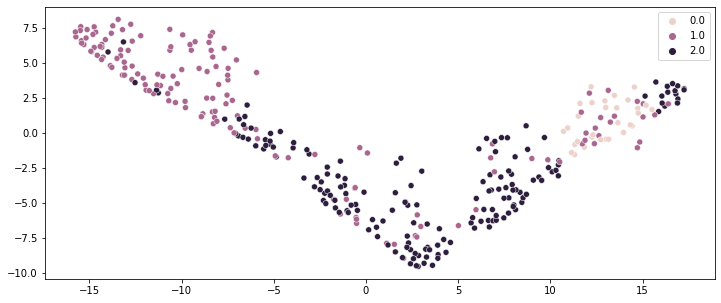

In [899]:
fig = plt.figure(figsize=(12, 5))
sns.scatterplot(x=XX.T[0], y=XX.T[1], hue=predictions1.T[0],)

In [900]:
rfm_table_cleaned['Cluster']=predictions1.T[0]

In [901]:
rfm_mean = rfm_table_cleaned.groupby(['Cluster']).agg(
    Recency_mean=pd.NamedAgg(column='Recency', aggfunc='mean'),
    Frequency_mean=pd.NamedAgg(column="Frequency", aggfunc='mean'),
    Monetary_mean=pd.NamedAgg(column='Monetary_Value', aggfunc='mean'),
)
rfm_mean_round = rfm_mean.round(0)
rfm_mean_round

,Recency_mean,Frequency_mean,Monetary_mean
Cluster,,,
0.0,41.0,58.0,8345508.0
1.0,180.0,17.0,1922716.0
2.0,55.0,21.0,2743624.0


In [902]:
plot_cluster_profile(rfm_mean, 3)

Кластер 0 соответствует «лояльным» клиентам, которые приносят наибольший доход, совершают покупки чаще всего, а давность их последней покупки наименьшая.
Кластер 2 соответствует «перспективным» клиентам, которые являются активными покупателями, но покупают не так часто и не так много, как лояльные клиенты.
Кластер 1 соответствует «подвисшим» клиентам, которые относительно недавно сделали несколько заказов на небольшие суммы. Потенциально эти клиенты могут быть переведены в кластер «перспективных».